# Tune the algorithms designed for stationary environments

In this notebook I tune the hyper parameters of those algorithms that were designed to work in stationary environments. These include: Epsilon-greedy, UCB1, LinUCB and SimOOS

For this I run them on the first 5000 points of the dataset without introducing non-stationarity.
In later experiments i will use the tuned parameters for these algorithms.

Here I use contexts of size 5 (same as in experiment 14_01).

In [1]:
import os
os.chdir("../..")
os.getcwd()

'/Users/sbokupripeku/git/work/examples/costly_nonstationary_bandits'

In [2]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

import algorithms
import evaluation
import costs
from plotting.costs import plot_costs

In [3]:
np.random.seed(42)

In [4]:
csv_file = 'experiments/nursery/nursery.csv'

In [5]:
df = pd.read_csv(csv_file)

In [6]:
df

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [7]:
df_num = df.astype('category')

In [8]:
df_num['final evaluation']

0         recommend
1          priority
2         not_recom
3         recommend
4          priority
            ...    
12955    spec_prior
12956     not_recom
12957    spec_prior
12958    spec_prior
12959     not_recom
Name: final evaluation, Length: 12960, dtype: category
Categories (5, object): ['not_recom', 'priority', 'recommend', 'spec_prior', 'very_recom']

In [9]:
# Order categories correctly, because order has meaning.
df_num.parents = df_num.parents.cat.reorder_categories(['usual', 'pretentious', 'great_pret'])
df_num.has_nurs = df_num.has_nurs.cat.reorder_categories(
    ['proper', 'less_proper',  'improper', 'critical', 'very_crit']
)
df_num.form = df_num.form.cat.reorder_categories(['complete', 'completed', 'incomplete', 'foster'])
df_num.children = df_num.children.cat.reorder_categories(['1', '2', '3', 'more'])
df_num.housing = df_num.housing.cat.reorder_categories(['convenient', 'less_conv', 'critical'])
df_num.finance = df_num.finance.cat.reorder_categories(['convenient', 'inconv'])
df_num.social = df_num.social.cat.reorder_categories(['nonprob', 'slightly_prob', 'problematic'])
df_num.health = df_num.health.cat.reorder_categories(['not_recom', 'recommended', 'priority'])
df_num['final evaluation'] = df_num['final evaluation'].cat.reorder_categories(
    ['not_recom', 'recommend',  'very_recom', 'priority', 'spec_prior',]
)


In [10]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,usual,proper,complete,1,convenient,convenient,nonprob,recommended,recommend
1,usual,proper,complete,1,convenient,convenient,nonprob,priority,priority
2,usual,proper,complete,1,convenient,convenient,nonprob,not_recom,not_recom
3,usual,proper,complete,1,convenient,convenient,slightly_prob,recommended,recommend
4,usual,proper,complete,1,convenient,convenient,slightly_prob,priority,priority
...,...,...,...,...,...,...,...,...,...
12955,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,priority,spec_prior
12956,great_pret,very_crit,foster,more,critical,inconv,slightly_prob,not_recom,not_recom
12957,great_pret,very_crit,foster,more,critical,inconv,problematic,recommended,spec_prior
12958,great_pret,very_crit,foster,more,critical,inconv,problematic,priority,spec_prior


In [11]:
for colname in df:
    df_num[colname] = df_num[colname].cat.codes + 1

In [12]:
df_num

,parents,has_nurs,form,children,housing,finance,social,health,final evaluation
0,1,1,1,1,1,1,1,2,2
1,1,1,1,1,1,1,1,3,4
2,1,1,1,1,1,1,1,1,1
3,1,1,1,1,1,1,2,2,2
4,1,1,1,1,1,1,2,3,4
...,...,...,...,...,...,...,...,...,...
12955,3,5,4,4,3,2,2,3,5
12956,3,5,4,4,3,2,2,1,1
12957,3,5,4,4,3,2,3,2,5
12958,3,5,4,4,3,2,3,3,5


In [13]:
# final evaluation is target variable

all_contexts = df_num.drop(['social', 'finance', 'final evaluation'], axis=1)

# In this notebook also drop children column. In next we'll try how it goes together with this column.

all_contexts = all_contexts.drop(['housing'], axis=1).to_numpy()

In [14]:
all_contexts.shape

(12960, 5)

In [15]:
all_contexts

array([[1, 1, 1, 1, 2],
       [1, 1, 1, 1, 3],
       [1, 1, 1, 1, 1],
       ...,
       [3, 5, 4, 4, 2],
       [3, 5, 4, 4, 3],
       [3, 5, 4, 4, 1]], dtype=int8)

In [16]:
y = df_num['final evaluation']

In [17]:
y.value_counts()

1    4320
4    4266
5    4044
3     328
2       2
Name: final evaluation, dtype: int64

In [18]:
# Drop arms with small rewards

In [19]:
# Values meaning:
# not recommended (1)
# recommend (2)
# very recommend (3)
# priority acceptance (4)
# special priority (5)

In [20]:
(y != 3) & (y != 2)

0        False
1         True
2         True
3        False
4         True
         ...  
12955     True
12956     True
12957     True
12958     True
12959     True
Name: final evaluation, Length: 12960, dtype: bool

In [21]:
all_contexts = all_contexts[(y != 3) & (y != 2)]

In [22]:
y = y[(y != 3) & (y != 2)]

In [23]:
y.value_counts()

1    4320
4    4266
5    4044
Name: final evaluation, dtype: int64

In [24]:
np.sum(np.where(y == 3, 1, 0))

0

In [25]:
unique = np.unique(y)
all_rewards = np.zeros((y.shape[0], len(unique)))
for n_arm, y_value in enumerate(unique):
    all_rewards[:, n_arm] = np.where(y == y_value, 1, 0)
    

In [26]:
all_rewards

array([[0., 1., 0.],
       [1., 0., 0.],
       [0., 1., 0.],
       ...,
       [0., 0., 1.],
       [0., 0., 1.],
       [1., 0., 0.]])

In [27]:
np.array(np.sum(all_rewards, axis=0), dtype=int)

array([4320, 4266, 4044])

## Algorithm evaluation

In [28]:
BETA = 1

In [29]:
def plot_gains(gain_dict, change_points=()):
    fig, ax = plt.subplots(1,1, figsize=(11, 6));
        
    max_vline=0
    
    ind_to_params = {
        # ind: (mark, color)
        0: ('x', 'k'),
        1: ('o','g'),
        2: ('s','r'),
        3: ('^','blue'),
        4: ('d','olive'),
        5: ('>', 'm'),
        6: ('*', 'c'),
        7: ('<', 'y'),
    }
    
    sorted_gain_dict = {
        k:v for k,v in sorted(gain_dict.items(), key=lambda x: x[1][-1], reverse=True)
    }
    
    for ind, (label, gain) in enumerate(sorted_gain_dict.items()):
        
        mark, color = ind_to_params[ind]
        ax.plot(gain, label=label, linestyle=':', marker=mark, markevery=750, fillstyle='none', color=color)
        max_vline=max(max_vline, max(gain))
    
    extraticks = [1, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 12960]
    plt.xticks(list(plt.xticks()[0][2:-1]) + extraticks, rotation=35, fontsize=16)
    plt.yticks(fontsize=16)
    
    ax.set_xlabel('Time step', fontsize=20)
    ax.set_ylabel('Cumulative gain', fontsize=20)
    


    plt.legend(prop={'size': 16});
    plt.show();

In [30]:
new_rewards = np.copy(all_rewards)
new_contexts = np.copy(all_contexts)

mean_rewards = np.ones(new_rewards.shape)*np.mean(new_rewards, axis=0)

n_arms = all_rewards.shape[1]



In [31]:
new_contexts.shape, new_rewards.shape

((12630, 5), (12630, 3))

### Stationary costs

In [32]:
cost_change_points = []
interval_count = len(cost_change_points) + 1

In [33]:
# Mean of gaussian distribution random in interval [0, 0.02] 
interval_means = [np.random.uniform(0.01, 0.03, size=(new_contexts.shape[1],)) for i in range(interval_count)]

In [34]:
interval_means

[array([0.0174908 , 0.02901429, 0.02463988, 0.02197317, 0.01312037])]

In [35]:
# Fixed std
interval_stds = [[0.001]*new_contexts.shape[1]]*interval_count

In [36]:
def get_costs():
    return costs.NonstationaryGaussianCosts(
        feature_vector_size=new_contexts.shape[1],
        change_points=cost_change_points,
        interval_means=interval_means,
        interval_stds=interval_stds,
        random_seed=42,
    )
    

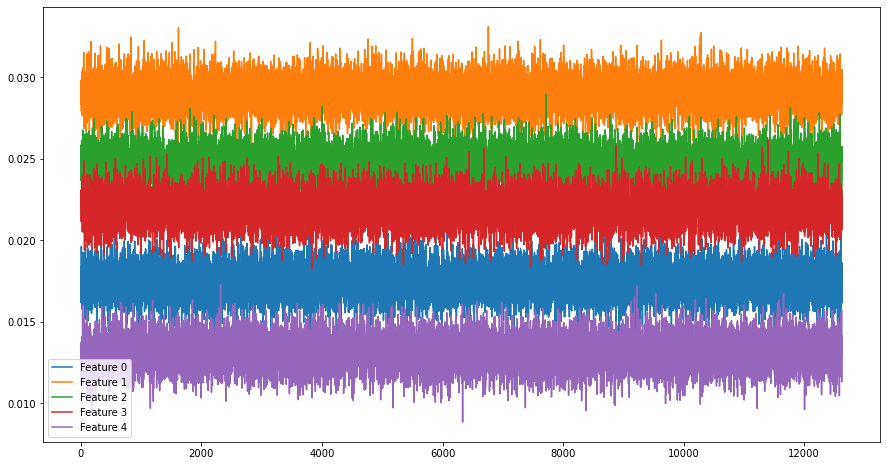

In [37]:
plot_costs(get_costs(), new_contexts.shape[0])

In [38]:
costs_obj = get_costs()

In [39]:
costs_vector = []
for t in range(new_contexts.shape[0]):
    costs_at_t = np.array(costs_obj.get_separate_costs(trial=t))
    costs_vector.append(costs_at_t)

costs_vector = np.stack(costs_vector)

In [40]:
costs_vector.shape

(12630, 5)

## Plot expected reward

Min expected reward for arm 1: 0.342042755344418
Min expected reward for arm 2: 0.33776722090261285
Min expected reward for arm 3: 0.3201900237529691


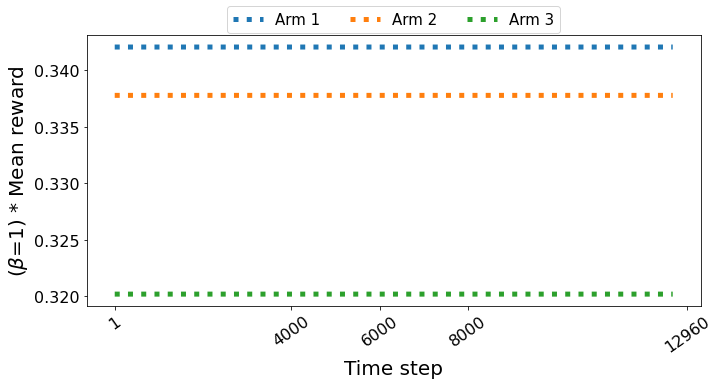

In [41]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] 
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected reward for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 4000, 6000, 8000, 12960]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Plot expected reward minus sum of costs

Min expected gain for arm 1: 0.22641281645726305
Min expected gain for arm 2: 0.22213728201545788
Min expected gain for arm 3: 0.20456008486581415


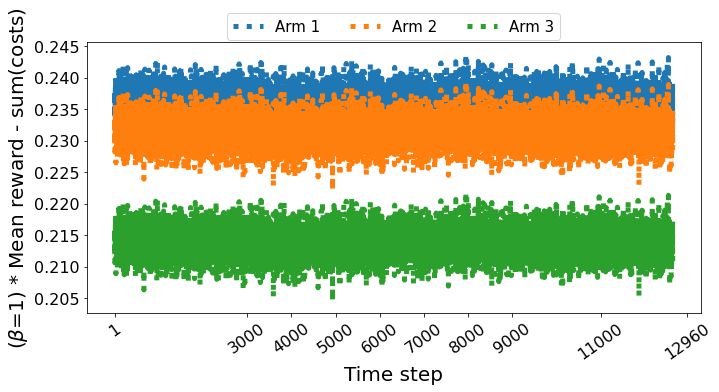

In [42]:
fig, ax = plt.subplots(1,1, figsize=(11,5))
for arm in range(n_arms):
    sum_of_costs = np.sum(costs_vector, axis=1)
    expected_gain = BETA * mean_rewards[:, arm] - sum_of_costs
    ax.plot(expected_gain, label=f"Arm {arm+1}", linestyle=':', linewidth=5)
    print(f"Min expected gain for arm {arm+1}: {min(expected_gain)}")

    
extraticks = [1, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 11000, 12960]
plt.xticks(extraticks, rotation=35, fontsize=16)

plt.yticks(fontsize=16)

ax.set_xlabel('Time step', fontsize=20)
ax.set_ylabel(fr"($\beta$={BETA}) * Mean reward - sum(costs)", fontsize=20)

lgd = ax.legend(loc=9, ncol=5, bbox_to_anchor=(0.5, 1.132), prop={'size': 15})
plt.savefig('mean_rewards.pdf', dpi=300, bbox_extra_artists=(lgd,), bbox_inches='tight')


plt.show()


## Testing on non-stationary data

In [43]:
np.random.seed(42)

In [44]:
TUNING_NUM_OF_TRIALS = 5000
NUM_OF_TRIALS = all_contexts.shape[0]
NUM_REPETITIONS = 5

## Epsilon-greedy

In [45]:
egreedy_gains = {}

for eps in [0.001, 0.003, 0.005, 0.008, 0.01, 0.03, 0.05, 0.08, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):
        egreedy = algorithms.EpsilonGreedy(epsilon=eps, n_arms=new_rewards.shape[1])

        gain_egreedy = evaluation.evaluate_on_synthetic_data(
            egreedy,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_egreedy

    gain_egreedy = np.mean(gains, axis=0)
    egreedy_gains[eps] = gain_egreedy

E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1836.0
	Total reward: 1836.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 2241.0
	Total reward: 2241.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1761.0
	Total reward: 1761.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1758.0
	Total reward: 1758.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.001)
Beta = 1
Total gain: 1761.0
	Total reward: 1761.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 2361.0
	Total reward: 2361.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 1756.0
	Total reward: 1756.0
	Total cost: 0
Execution time: 0.0s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 2182.0
	Total reward: 2182.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.003)
Beta = 1
Total gain: 2609.0
	Total reward: 2609.0
	Total cost: 0
Execution time: 0.0s
E-greedy(e

In [46]:
last_gains = {k:v[-1] for k,v in egreedy_gains.items()}
best_eps = sorted(last_gains.items(), key=lambda x: x[1])[-1][0];
best_eps

0.01

In [47]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):
    egreedy = algorithms.EpsilonGreedy(epsilon=best_eps, n_arms=new_rewards.shape[1])

    gain_egreedy = evaluation.evaluate_on_synthetic_data(
        egreedy,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_egreedy
    
gain_egreedy = np.mean(gains, axis=0)
print(f"Average gain: {gain_egreedy[-1]}")

E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4213.0
	Total reward: 4213.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4256.0
	Total reward: 4256.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4508.0
	Total reward: 4508.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4144.0
	Total reward: 4144.0
	Total cost: 0
Execution time: 0.1s
E-greedy(epsilon=0.01)
Beta = 1
Total gain: 4172.0
	Total reward: 4172.0
	Total cost: 0
Execution time: 0.1s
Average gain: 4258.6


## UCB1

In [48]:
ucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        ucb_alg = algorithms.UCB1(
                n_trials=TUNING_NUM_OF_TRIALS,
                n_arms=new_rewards.shape[1],
                alpha=alpha,
            )

        gain_ucb = evaluation.evaluate_on_synthetic_data(
            ucb_alg,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_ucb

    gain_ucb = np.mean(gains, axis=0)
    ucb_gains[alpha] = gain_ucb

UCB1 (α=0.001)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.001)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.005)
Beta = 1
Total gain: 1760.0
	Total reward: 1760.0
	Total cost: 0
Execution t

In [49]:
last_gains = {k:v[-1] for k,v in ucb_gains.items()}
best_alpha_ucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_ucb

0.8

In [50]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    ucb_alg = algorithms.UCB1(
            n_trials=NUM_OF_TRIALS,
            n_arms=new_rewards.shape[1],
            alpha=best_alpha_ucb,
        )

    gain_ucb = evaluation.evaluate_on_synthetic_data(
        ucb_alg,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_ucb

gain_ucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_ucb[-1]}")

UCB1 (α=0.8)
Beta = 1
Total gain: 6709.0
	Total reward: 6709.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.8)
Beta = 1
Total gain: 6709.0
	Total reward: 6709.0
	Total cost: 0
Execution time: 0.1s
UCB1 (α=0.8)
Beta = 1
Total gain: 6709.0
	Total reward: 6709.0
	Total cost: 0
Execution time: 0.2s
UCB1 (α=0.8)
Beta = 1
Total gain: 6709.0
	Total reward: 6709.0
	Total cost: 0
Execution time: 0.2s
UCB1 (α=0.8)
Beta = 1
Total gain: 6709.0
	Total reward: 6709.0
	Total cost: 0
Execution time: 0.2s
Average gain: 6709.0


## LinUCB

In [51]:
linucb_gains = {}

for alpha in [0.001, 0.005, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        linucb = algorithms.LinUCB(
            n_trials=TUNING_NUM_OF_TRIALS,
            context_dimension=new_contexts.shape[1],
            n_arms=new_rewards.shape[1],
            alpha=alpha,
        )
        gain_linucb = evaluation.evaluate_on_synthetic_data(
            linucb,
            new_contexts,
            new_rewards,
            costs_vector,
            beta=BETA,
            stop_after=TUNING_NUM_OF_TRIALS,
        )
        gains[i, :] = gain_linucb

    gain_linucb = np.mean(gains, axis=0)
    linucb_gains[alpha] = gain_linucb

LinUCB (alpha=0.001)
Beta = 1
Total gain: 3640.5993981778183
	Total reward: 4172.0
	Total cost: 531.4006018221771
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 3640.5993981778183
	Total reward: 4172.0
	Total cost: 531.4006018221771
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 3640.5993981778183
	Total reward: 4172.0
	Total cost: 531.4006018221771
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 3640.5993981778183
	Total reward: 4172.0
	Total cost: 531.4006018221771
Execution time: 0.3s
LinUCB (alpha=0.001)
Beta = 1
Total gain: 3640.5993981778183
	Total reward: 4172.0
	Total cost: 531.4006018221771
Execution time: 0.4s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 3641.5993981778183
	Total reward: 4173.0
	Total cost: 531.4006018221771
Execution time: 0.3s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 3641.5993981778183
	Total reward: 4173.0
	Total cost: 531.4006018221771
Execution time: 0.3s
LinUCB (alpha=0.005)
Beta = 1
Total gain: 3641.59939817

LinUCB (alpha=0.9)
Beta = 1
Total gain: 4086.5993981778183
	Total reward: 4618.0
	Total cost: 531.4006018221771
Execution time: 0.3s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 4086.5993981778183
	Total reward: 4618.0
	Total cost: 531.4006018221771
Execution time: 0.3s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 4086.5993981778183
	Total reward: 4618.0
	Total cost: 531.4006018221771
Execution time: 0.3s


In [52]:
last_gains = {k:v[-1] for k,v in linucb_gains.items()}
best_alpha_linucb = sorted(last_gains.items(), key=lambda x: x[1])[-1][0]
best_alpha_linucb

0.9

In [53]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    linucb = algorithms.LinUCB(
        n_trials=NUM_OF_TRIALS,
        context_dimension=new_contexts.shape[1],
        n_arms=new_rewards.shape[1],
        alpha=best_alpha_linucb,
    )
    gain_linucb = evaluation.evaluate_on_synthetic_data(
        linucb,
        new_contexts,
        new_rewards,
        costs_vector,
        beta=BETA,
        stop_after=NUM_OF_TRIALS,
    )
    gains[i, :] = gain_linucb

gain_linucb = np.mean(gains, axis=0)
print(f"Average gain: {gain_linucb[-1]}")

LinUCB (alpha=0.9)
Beta = 1
Total gain: 7064.287209089602
	Total reward: 8406.0
	Total cost: 1341.7127909104004
Execution time: 0.8s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 7064.287209089602
	Total reward: 8406.0
	Total cost: 1341.7127909104004
Execution time: 0.9s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 7064.287209089602
	Total reward: 8406.0
	Total cost: 1341.7127909104004
Execution time: 0.9s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 7064.287209089602
	Total reward: 8406.0
	Total cost: 1341.7127909104004
Execution time: 0.9s
LinUCB (alpha=0.9)
Beta = 1
Total gain: 7064.287209089602
	Total reward: 8406.0
	Total cost: 1341.7127909104004
Execution time: 0.9s
Average gain: 7064.287209089601


## SimOOS

In [54]:
simoos_gains = {}


for delta in [0.005, 0.01, 0.03, 0.05, 0.08, 0.09, 0.1, 0.12, 0.16, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99]:
    gains = np.zeros((NUM_REPETITIONS, TUNING_NUM_OF_TRIALS))
    for i in range(NUM_REPETITIONS):

        s = time.time()
        p_simoos = algorithms.SimOOSAlgorithm(
            all_contexts=new_contexts, 
            number_of_actions=new_rewards.shape[1],
            max_no_red_context=new_contexts.shape[1],
            beta_SimOOS=BETA,
            delta_SimOOS=delta,
        )
        print(f"Took {time.time() - s} seconds")

        import warnings
        with warnings.catch_warnings():
            warnings.simplefilter("ignore")
            s = time.time()
            gain_simoos = evaluation.evaluate_on_synthetic_data(
                p_simoos,
                new_contexts[:TUNING_NUM_OF_TRIALS],
                new_rewards[:TUNING_NUM_OF_TRIALS],
                costs_vector[:TUNING_NUM_OF_TRIALS],
                beta=BETA,
                stop_after=TUNING_NUM_OF_TRIALS,
            )
            print(f"Took {time.time() - s} seconds")
        gains[i, :] = gain_simoos

    gain_simoos = np.mean(gains, axis=0)
    simoos_gains[delta] = gain_simoos

Took 0.003036022186279297 seconds
Trial 0, time 2022-05-10 17:01:16.558913
Trial 500, time 2022-05-10 17:01:44.164414
Trial 1000, time 2022-05-10 17:02:08.823188
Trial 1500, time 2022-05-10 17:02:34.233819
Trial 2000, time 2022-05-10 17:03:01.449807
Trial 2500, time 2022-05-10 17:03:27.167512
Trial 3000, time 2022-05-10 17:03:56.592571
Trial 3500, time 2022-05-10 17:04:22.564944
Trial 4000, time 2022-05-10 17:04:48.364417
Trial 4500, time 2022-05-10 17:05:15.121970
SimOOS (beta=1, delta=0.005)
Beta = 1
Total gain: 3562.2970354284844
	Total reward: 4092.0
	Total cost: 529.7029645715096
Execution time: 4.4m
Took 265.059996843338 seconds
Took 0.003565073013305664 seconds
Trial 0, time 2022-05-10 17:05:41.622950
Trial 500, time 2022-05-10 17:06:09.130861
Trial 1000, time 2022-05-10 17:06:35.633573
Trial 1500, time 2022-05-10 17:07:02.256366
Trial 2000, time 2022-05-10 17:07:30.418925
Trial 2500, time 2022-05-10 17:07:57.764723
Trial 3000, time 2022-05-10 17:08:28.493284
Trial 3500, time 20

SimOOS (beta=1, delta=0.03)
Beta = 1
Total gain: 2412.9268501184415
	Total reward: 2733.0
	Total cost: 320.07314988155997
Execution time: 1.1m
Took 66.42168593406677 seconds
Took 0.003689289093017578 seconds
Trial 0, time 2022-05-10 17:35:30.733364
Trial 500, time 2022-05-10 17:35:59.367584
Trial 1000, time 2022-05-10 17:36:15.525580
Trial 1500, time 2022-05-10 17:36:17.864611
Trial 2000, time 2022-05-10 17:36:18.892792
Trial 2500, time 2022-05-10 17:36:19.493539
Trial 3000, time 2022-05-10 17:36:19.938889
Trial 3500, time 2022-05-10 17:36:20.546344
Trial 4000, time 2022-05-10 17:36:20.980540
Trial 4500, time 2022-05-10 17:36:21.365463
SimOOS (beta=1, delta=0.03)
Beta = 1
Total gain: 3820.601379051482
	Total reward: 4119.0
	Total cost: 298.39862094852475
Execution time: 51.0s
Took 50.99783802032471 seconds
Took 0.0069200992584228516 seconds
Trial 0, time 2022-05-10 17:36:21.739020
Trial 500, time 2022-05-10 17:36:34.925870
Trial 1000, time 2022-05-10 17:36:47.279868
Trial 1500, time 20

Trial 3000, time 2022-05-10 17:53:45.633769
Trial 3500, time 2022-05-10 17:53:57.502648
Trial 4000, time 2022-05-10 17:53:58.965538
Trial 4500, time 2022-05-10 17:54:10.418259
SimOOS (beta=1, delta=0.09)
Beta = 1
Total gain: 3733.492324067128
	Total reward: 4039.0
	Total cost: 305.50767593287406
Execution time: 1.3m
Took 75.85763835906982 seconds
Took 0.002962827682495117 seconds
Trial 0, time 2022-05-10 17:54:11.474068
Trial 500, time 2022-05-10 17:54:40.945330
Trial 1000, time 2022-05-10 17:55:07.203031
Trial 1500, time 2022-05-10 17:55:34.205834
Trial 2000, time 2022-05-10 17:56:02.193131
Trial 2500, time 2022-05-10 17:56:27.507099
Trial 3000, time 2022-05-10 17:56:55.596183
Trial 3500, time 2022-05-10 17:57:23.228384
Trial 4000, time 2022-05-10 17:57:49.848034
Trial 4500, time 2022-05-10 17:57:59.609431
SimOOS (beta=1, delta=0.09)
Beta = 1
Total gain: 3757.576881980668
	Total reward: 4200.0
	Total cost: 442.4231180193451
Execution time: 3.8m
Took 230.49768900871277 seconds
Took 0.0

Trial 1500, time 2022-05-10 18:26:50.478833
Trial 2000, time 2022-05-10 18:27:14.857552
Trial 2500, time 2022-05-10 18:27:37.590235
Trial 3000, time 2022-05-10 18:28:02.618975
Trial 3500, time 2022-05-10 18:28:26.278594
Trial 4000, time 2022-05-10 18:28:49.772202
Trial 4500, time 2022-05-10 18:28:56.892091
SimOOS (beta=1, delta=0.12)
Beta = 1
Total gain: 3753.156211558876
	Total reward: 4196.0
	Total cost: 442.84378844113684
Execution time: 3.5m
Took 208.78633785247803 seconds
Took 0.002620220184326172 seconds
Trial 0, time 2022-05-10 18:28:58.966480
Trial 500, time 2022-05-10 18:29:25.579764
Trial 1000, time 2022-05-10 18:29:40.388780
Trial 1500, time 2022-05-10 18:29:42.462712
Trial 2000, time 2022-05-10 18:29:43.342443
Trial 2500, time 2022-05-10 18:29:43.900597
Trial 3000, time 2022-05-10 18:29:44.264656
Trial 3500, time 2022-05-10 18:29:45.505021
Trial 4000, time 2022-05-10 18:29:45.886641
Trial 4500, time 2022-05-10 18:29:46.290208
SimOOS (beta=1, delta=0.12)
Beta = 1
Total gain:

Trial 500, time 2022-05-10 18:58:30.704551
Trial 1000, time 2022-05-10 18:58:54.771042
Trial 1500, time 2022-05-10 18:59:19.598967
Trial 2000, time 2022-05-10 18:59:44.871521
Trial 2500, time 2022-05-10 19:00:08.111397
Trial 3000, time 2022-05-10 19:00:33.730493
Trial 3500, time 2022-05-10 19:00:58.056756
Trial 4000, time 2022-05-10 19:01:22.273005
Trial 4500, time 2022-05-10 19:01:46.328735
SimOOS (beta=1, delta=0.3)
Beta = 1
Total gain: 3568.080455558784
	Total reward: 4097.0
	Total cost: 528.9195444412107
Execution time: 4.1m
Took 244.9309241771698 seconds
Took 0.00611114501953125 seconds
Trial 0, time 2022-05-10 19:02:08.827172
Trial 500, time 2022-05-10 19:02:19.330738
Trial 1000, time 2022-05-10 19:02:28.600034
Trial 1500, time 2022-05-10 19:02:29.695633
Trial 2000, time 2022-05-10 19:02:40.524090
Trial 2500, time 2022-05-10 19:02:45.647831
Trial 3000, time 2022-05-10 19:02:51.203855
Trial 3500, time 2022-05-10 19:03:00.924376
Trial 4000, time 2022-05-10 19:03:02.029127
Trial 450

Trial 500, time 2022-05-10 19:25:11.051793
Trial 1000, time 2022-05-10 19:25:24.363387
Trial 1500, time 2022-05-10 19:25:26.259214
Trial 2000, time 2022-05-10 19:25:27.058629
Trial 2500, time 2022-05-10 19:25:27.504085
Trial 3000, time 2022-05-10 19:25:27.825282
Trial 3500, time 2022-05-10 19:25:34.209744
Trial 4000, time 2022-05-10 19:25:45.822625
Trial 4500, time 2022-05-10 19:25:48.896478
SimOOS (beta=1, delta=0.5)
Beta = 1
Total gain: 3734.1016744316225
	Total reward: 4046.0
	Total cost: 311.8983255683917
Execution time: 1.0m
Took 62.447129011154175 seconds
Took 0.002311229705810547 seconds
Trial 0, time 2022-05-10 19:25:49.253886
Trial 500, time 2022-05-10 19:26:13.072797
Trial 1000, time 2022-05-10 19:26:28.031863
Trial 1500, time 2022-05-10 19:26:29.925340
Trial 2000, time 2022-05-10 19:26:30.877370
Trial 2500, time 2022-05-10 19:26:31.372058
Trial 3000, time 2022-05-10 19:26:31.659369
Trial 3500, time 2022-05-10 19:26:32.078221
Trial 4000, time 2022-05-10 19:26:32.361348
Trial 

Trial 500, time 2022-05-10 19:48:47.345318
Trial 1000, time 2022-05-10 19:49:12.325276
Trial 1500, time 2022-05-10 19:49:38.020971
Trial 2000, time 2022-05-10 19:50:04.559718
Trial 2500, time 2022-05-10 19:50:28.636299
Trial 3000, time 2022-05-10 19:50:55.329005
Trial 3500, time 2022-05-10 19:51:20.676749
Trial 4000, time 2022-05-10 19:51:45.903081
Trial 4500, time 2022-05-10 19:51:53.872853
SimOOS (beta=1, delta=0.8)
Beta = 1
Total gain: 3754.2324207505135
	Total reward: 4197.0
	Total cost: 442.7675792494998
Execution time: 3.6m
Took 218.30625700950623 seconds
Took 0.0038797855377197266 seconds
Trial 0, time 2022-05-10 19:51:56.143188
Trial 500, time 2022-05-10 19:52:24.866426
Trial 1000, time 2022-05-10 19:52:42.071455
Trial 1500, time 2022-05-10 19:52:44.294943
Trial 2000, time 2022-05-10 19:52:45.236002
Trial 2500, time 2022-05-10 19:52:45.890101
Trial 3000, time 2022-05-10 19:52:46.340941
Trial 3500, time 2022-05-10 19:52:50.422857
Trial 4000, time 2022-05-10 19:52:50.810548
Trial

In [55]:
last_gains = {k:v[-1] for k,v in simoos_gains.items()}
best_delta_simoos  = sorted(
    last_gains.items(), key=lambda x: x[1]
)[-1][0]
best_delta_simoos

0.2

In [56]:
gains = np.zeros((NUM_REPETITIONS, NUM_OF_TRIALS))
for i in range(NUM_REPETITIONS):

    s = time.time()
    p_simoos = algorithms.SimOOSAlgorithm(
        all_contexts=new_contexts, 
        number_of_actions=new_rewards.shape[1],
        max_no_red_context=new_contexts.shape[1],
        beta_SimOOS=BETA,
        delta_SimOOS=best_delta_simoos,
    )
    print(f"Took {time.time() - s} seconds")

    import warnings
    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
        s = time.time()
        gain_simoos = evaluation.evaluate_on_synthetic_data(
            p_simoos,
            new_contexts[:NUM_OF_TRIALS],
            new_rewards[:NUM_OF_TRIALS],
            costs_vector[:NUM_OF_TRIALS],
            beta=BETA,
            stop_after=NUM_OF_TRIALS,
        )
        print(f"Took {time.time() - s} seconds")
    gains[i, :] = gain_simoos

gain_simoos = np.mean(gains, axis=0)
print(f"Average gain: {gain_simoos[-1]}")

Took 0.002665996551513672 seconds
Trial 0, time 2022-05-10 20:24:24.349510
Trial 500, time 2022-05-10 20:24:36.261604
Trial 1000, time 2022-05-10 20:24:46.887385
Trial 1500, time 2022-05-10 20:24:48.217466
Trial 2000, time 2022-05-10 20:24:59.274206
Trial 2500, time 2022-05-10 20:25:05.156743
Trial 3000, time 2022-05-10 20:25:11.434115
Trial 3500, time 2022-05-10 20:25:22.492325
Trial 4000, time 2022-05-10 20:25:23.664601
Trial 4500, time 2022-05-10 20:25:24.048695
Trial 5000, time 2022-05-10 20:25:24.580238
Trial 5500, time 2022-05-10 20:25:24.964509
Trial 6000, time 2022-05-10 20:25:25.545673
Trial 6500, time 2022-05-10 20:25:26.105211
Trial 7000, time 2022-05-10 20:25:26.517119
Trial 7500, time 2022-05-10 20:25:27.048166
Trial 8000, time 2022-05-10 20:25:27.425028
Trial 8500, time 2022-05-10 20:25:27.989192
Trial 9000, time 2022-05-10 20:25:28.402652
Trial 9500, time 2022-05-10 20:25:28.745399
Trial 10000, time 2022-05-10 20:25:29.143983
Trial 10500, time 2022-05-10 20:25:29.478121


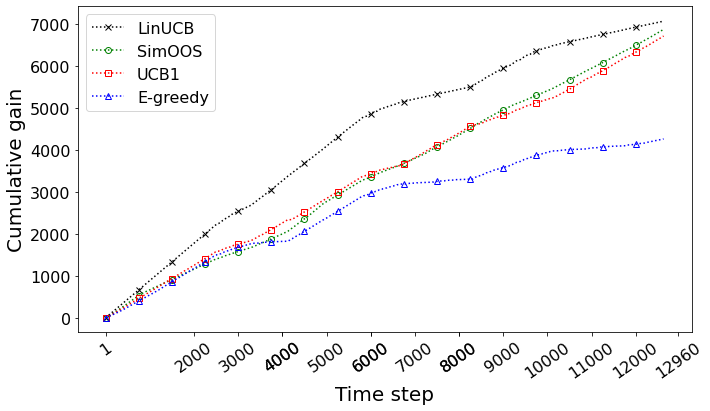

In [57]:
plot_gains({
    'E-greedy': gain_egreedy,
    'UCB1': gain_ucb,
    'LinUCB': gain_linucb,
    'SimOOS': gain_simoos,
},
)


In [58]:
best_eps # Epsilon-greedy

0.01

In [59]:
best_alpha_ucb # UCB1

0.8

In [60]:
best_alpha_linucb # LinUCB

0.9

In [61]:
best_delta_simoos # SimOOS

0.2